In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv("testing_cleaned.csv")
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [3]:
NUMERIC = [
    'Hours_Studied','Attendance','Sleep_Hours','Previous_Scores',
    'Tutoring_Sessions','Physical_Activity'
]

CATEGORICAL = [
    'Parental_Involvement','Access_to_Resources','Extracurricular_Activities',
    'Motivation_Level','Internet_Access','Family_Income','Teacher_Quality',
    'School_Type','Peer_Influence','Learning_Disabilities',
    'Parental_Education_Level','Distance_from_Home','Gender'
]

TARGET = 'Performance'

In [5]:
# Ensure the target exists in this notebook
print("Columns:", sorted(df.columns.tolist()))

# 1) sanity check: we need Exam_Score to derive Performance
assert 'Exam_Score' in df.columns, "Exam_Score not found in the dataframe."

# 2) create Performance if missing
if 'Performance' not in df.columns:
    # clean & coerce just in case
    df['Exam_Score'] = pd.to_numeric(df['Exam_Score'], errors='coerce')

    # bin into Low / Medium / High (adjust cutoffs if your lecturer wants different ones)
    bins   = [-1, 60, 80, 1e9]
    labels = ['Low', 'Medium', 'High']
    df['Performance'] = pd.cut(df['Exam_Score'], bins=bins, labels=labels)

# 3) verify no NaNs in target (rare if scores are in range)
print("Target nulls:", df['Performance'].isna().sum())
print(df['Performance'].value_counts(dropna=False, normalize=True))

# (optional) drop rows with missing target if any
df = df.dropna(subset=['Performance']).copy()

Columns: ['Access_to_Resources', 'Attendance', 'Distance_from_Home', 'Exam_Score', 'Extracurricular_Activities', 'Family_Income', 'Gender', 'Hours_Studied', 'Internet_Access', 'Learning_Disabilities', 'Motivation_Level', 'Parental_Education_Level', 'Parental_Involvement', 'Peer_Influence', 'Physical_Activity', 'Previous_Scores', 'School_Type', 'Sleep_Hours', 'Teacher_Quality', 'Tutoring_Sessions']
Target nulls: 0
Performance
Medium    0.971545
Low       0.021946
High      0.006508
Name: proportion, dtype: float64


In [6]:
X = df[NUMERIC + CATEGORICAL]
y = df['Performance']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.value_counts(normalize=True))

(5285, 19) (1322, 19) Performance
Medium    0.971618
Low       0.021949
High      0.006433
Name: proportion, dtype: float64


In [7]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, NUMERIC),
    ("cat", categorical_transformer, CATEGORICAL)
])

In [8]:
logreg_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=200))
])

logreg_pipe.fit(X_train, y_train)
y_pred_lr = logreg_pipe.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         9
         Low       1.00      0.76      0.86        29
      Medium       0.99      1.00      0.99      1284

    accuracy                           0.99      1322
   macro avg       0.66      0.59      0.62      1322
weighted avg       0.98      0.99      0.98      1322



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         9
         Low       0.00      0.00      0.00        29
      Medium       0.97      1.00      0.99      1284

    accuracy                           0.97      1322
   macro avg       0.32      0.33      0.33      1322
weighted avg       0.94      0.97      0.96      1322



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


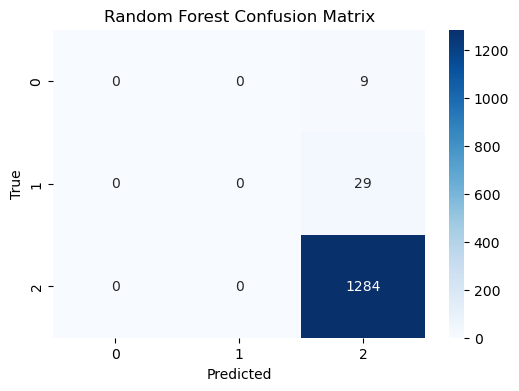

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [11]:
y.value_counts(dropna=False), y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Performance
 Medium    6419
 Low        145
 High        43
 Name: count, dtype: int64,
 Performance
 Medium    0.971618
 Low       0.021949
 High      0.006433
 Name: proportion, dtype: float64,
 Performance
 Medium    0.971256
 Low       0.021936
 High      0.006808
 Name: proportion, dtype: float64)

In [12]:
# Rebuild Performance using quantiles (≈ same count per class)
df['Performance'] = pd.qcut(
    df['Exam_Score'].rank(method='first'),  # avoid duplicate-bin issues
    q=[0, 1/3, 2/3, 1.0],
    labels=['Low','Medium','High']
)

# Re-split with new target
X = df[NUMERIC + CATEGORICAL]
y = df['Performance']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Performance
 Medium    0.333396
 High      0.333396
 Low       0.333207
 Name: proportion, dtype: float64,
 Performance
 Low       0.333585
 High      0.333585
 Medium    0.332829
 Name: proportion, dtype: float64)

Logistic Regression (quantile target)
              precision    recall  f1-score   support

        High       0.95      0.96      0.96       441
         Low       0.95      0.95      0.95       441
      Medium       0.91      0.90      0.91       440

    accuracy                           0.94      1322
   macro avg       0.94      0.94      0.94      1322
weighted avg       0.94      0.94      0.94      1322

Random Forest (quantile target)
              precision    recall  f1-score   support

        High       0.83      0.88      0.86       441
         Low       0.86      0.86      0.86       441
      Medium       0.73      0.69      0.71       440

    accuracy                           0.81      1322
   macro avg       0.81      0.81      0.81      1322
weighted avg       0.81      0.81      0.81      1322



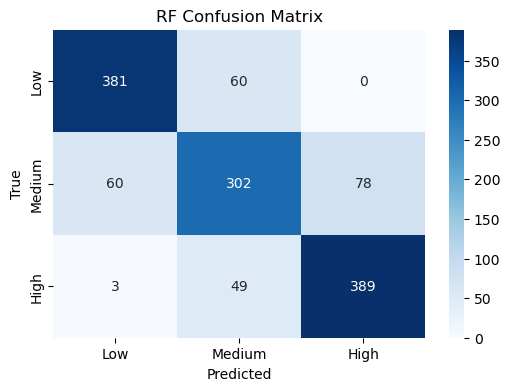

In [13]:
# Logistic Regression
logreg_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])
logreg_pipe.fit(X_train, y_train)
y_pred_lr = logreg_pipe.predict(X_test)
print("Logistic Regression (quantile target)")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Random Forest
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print("Random Forest (quantile target)")
print(classification_report(y_test, y_pred_rf, zero_division=0))

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf, labels=['Low','Medium','High']),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low','Medium','High'],
            yticklabels=['Low','Medium','High'])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("RF Confusion Matrix"); plt.show()

In [14]:
joblib.dump(rf_pipe, "random_forest_pipeline.joblib")

print("✅ Model saved as random_forest_pipeline.joblib in current notebook folder")

✅ Model saved as random_forest_pipeline.joblib in current notebook folder


In [15]:
MODEL_PATH = "random_forest_pipeline.joblib"  # same folder as this notebook

pipe = joblib.load(MODEL_PATH)
print("✅ model loaded")

✅ model loaded


In [16]:
# Fill these with reasonable values for a hypothetical student
record = {
    'Hours_Studied': 6,
    'Attendance': 92,
    'Sleep_Hours': 7,
    'Previous_Scores': 70,
    'Tutoring_Sessions': 1,
    'Physical_Activity': 3,
    'Parental_Involvement': 'Medium',
    'Access_to_Resources': 'Medium',
    'Extracurricular_Activities': 'Yes',
    'Motivation_Level': 'Medium',
    'Internet_Access': 'Yes',
    'Family_Income': 'Medium',
    'Teacher_Quality': 'Medium',
    'School_Type': 'Public',
    'Peer_Influence': 'Positive',
    'Learning_Disabilities': 'No',
    'Parental_Education_Level': 'High School',
    'Distance_from_Home': 'Near',
    'Gender': 'Male'
}

X_one = pd.DataFrame([record])
pred_one = pipe.predict(X_one)[0]
pred_proba = getattr(pipe.named_steps['clf'], "predict_proba", lambda X: None)
proba_one = pred_proba(pipe.named_steps['pre'].transform(X_one)) if pred_proba else None

print("🎯 Prediction:", pred_one)
if proba_one is not None:
    # show class order for probabilities
    classes = pipe.named_steps['clf'].classes_
    print("Class order:", classes)
    print("Probabilities:", dict(zip(classes, proba_one[0])))

🎯 Prediction: Medium
Class order: ['High' 'Low' 'Medium']
Probabilities: {'High': 0.2375, 'Low': 0.2725, 'Medium': 0.49}


In [17]:
in_path = "testing.csv"  # change if needed
df_in = pd.read_csv(in_path)

# Optional: ensure text columns are neat like earlier
for col in df_in.select_dtypes(include='object').columns:
    df_in[col] = df_in[col].astype(str).str.strip().str.title()

preds = pipe.predict(df_in)
df_out = df_in.copy()
df_out["Prediction"] = preds

print(df_out.head())

# Save results
out_path = "../data/batch_predictions.csv"
df_out.to_csv(out_path, index=False)
print(f"✅ Saved predictions to {out_path}")

   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions  ... Teacher_Quality School_Type  \
0            

In [18]:
import numpy as np

try:
    pre = pipe.named_steps['pre']                  # ColumnTransformer
    clf = pipe.named_steps['clf']                  # RandomForestClassifier
    ohe = pre.named_transformers_['cat'].named_steps['encoder']

    num_feats = pre.transformers_[0][2]            # NUMERIC list used in pipeline
    cat_feats_expanded = ohe.get_feature_names_out(pre.transformers_[1][2])  # expanded OHE names
    all_feats = list(num_feats) + list(cat_feats_expanded)

    importances = clf.feature_importances_
    imp_df = (pd.DataFrame({'feature': all_feats, 'importance': importances})
                .sort_values('importance', ascending=False))

    display(imp_df.head(20))

except Exception as e:
    print("Could not compute feature importances:", e)

,feature,importance
1,Attendance,0.257239
0,Hours_Studied,0.152575
3,Previous_Scores,0.080722
4,Tutoring_Sessions,0.040963
2,Sleep_Hours,0.040575
5,Physical_Activity,0.033862
9,Access_to_Resources_High,0.016009
30,Peer_Influence_Positive,0.013930
6,Parental_Involvement_High,0.013855
20,Family_Income_Low,0.013673
